In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Загрузка и предобработка данных

In [2]:
print("Загрузка данных...")
train_df = pd.read_csv('../data/train.csv')
print(f"Размер обучающей выборки: {train_df.shape}")

train_processed = train_df.copy()

if 'RiskScore' in train_processed.columns:
    y = train_processed['RiskScore'].copy()
    train_processed = train_processed.drop('RiskScore', axis=1)

numeric_cols = train_processed.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_processed.select_dtypes(include=['object']).columns.tolist()

# Заполнение пропусков для числовых признаков
for col in numeric_cols:
    median_value = train_processed[col].median()
    train_processed[col].fillna(median_value, inplace=True)

# Заполнение пропусков для категориальных признаков
for col in categorical_cols:
    mode_val = train_processed[col].mode()[0] if len(train_processed[col].mode()) > 0 else 'Unknown'
    train_processed[col].fillna(mode_val, inplace=True)

if 'ApplicationDate' in train_processed.columns:
    train_processed['ApplicationDate'] = pd.to_datetime(train_processed['ApplicationDate'])
    train_processed['Year'] = train_processed['ApplicationDate'].dt.year
    train_processed['Month'] = train_processed['ApplicationDate'].dt.month
    train_processed['DayOfWeek'] = train_processed['ApplicationDate'].dt.dayofweek
    train_processed = train_processed.drop('ApplicationDate', axis=1)
    numeric_cols.extend(['Year', 'Month', 'DayOfWeek'])
    if 'ApplicationDate' in categorical_cols:
        categorical_cols.remove('ApplicationDate')

for col in categorical_cols:
    if col in train_processed.columns:
        train_encoded = pd.get_dummies(train_processed[col], prefix=col, dummy_na=False)
        train_processed = train_processed.drop(col, axis=1)
        train_processed = pd.concat([train_processed, train_encoded], axis=1)

feature_cols = train_processed.columns.tolist()
X = train_processed[feature_cols].values.astype(np.float32)
y = y.values.astype(np.float32)

print(f"Количество признаков после предобработки: {X.shape[1]}")

mask = (y >= -100) & (y <= 100)
X = X[mask]
y = y[mask]

print(f"После фильтрации: X {X.shape}, y {y.shape}")

Загрузка данных...
Размер обучающей выборки: (11017, 35)
Количество признаков после предобработки: 52
После фильтрации: X (10272, 52), y (10272,)


## 2. Разведочный анализ данных (EDA)

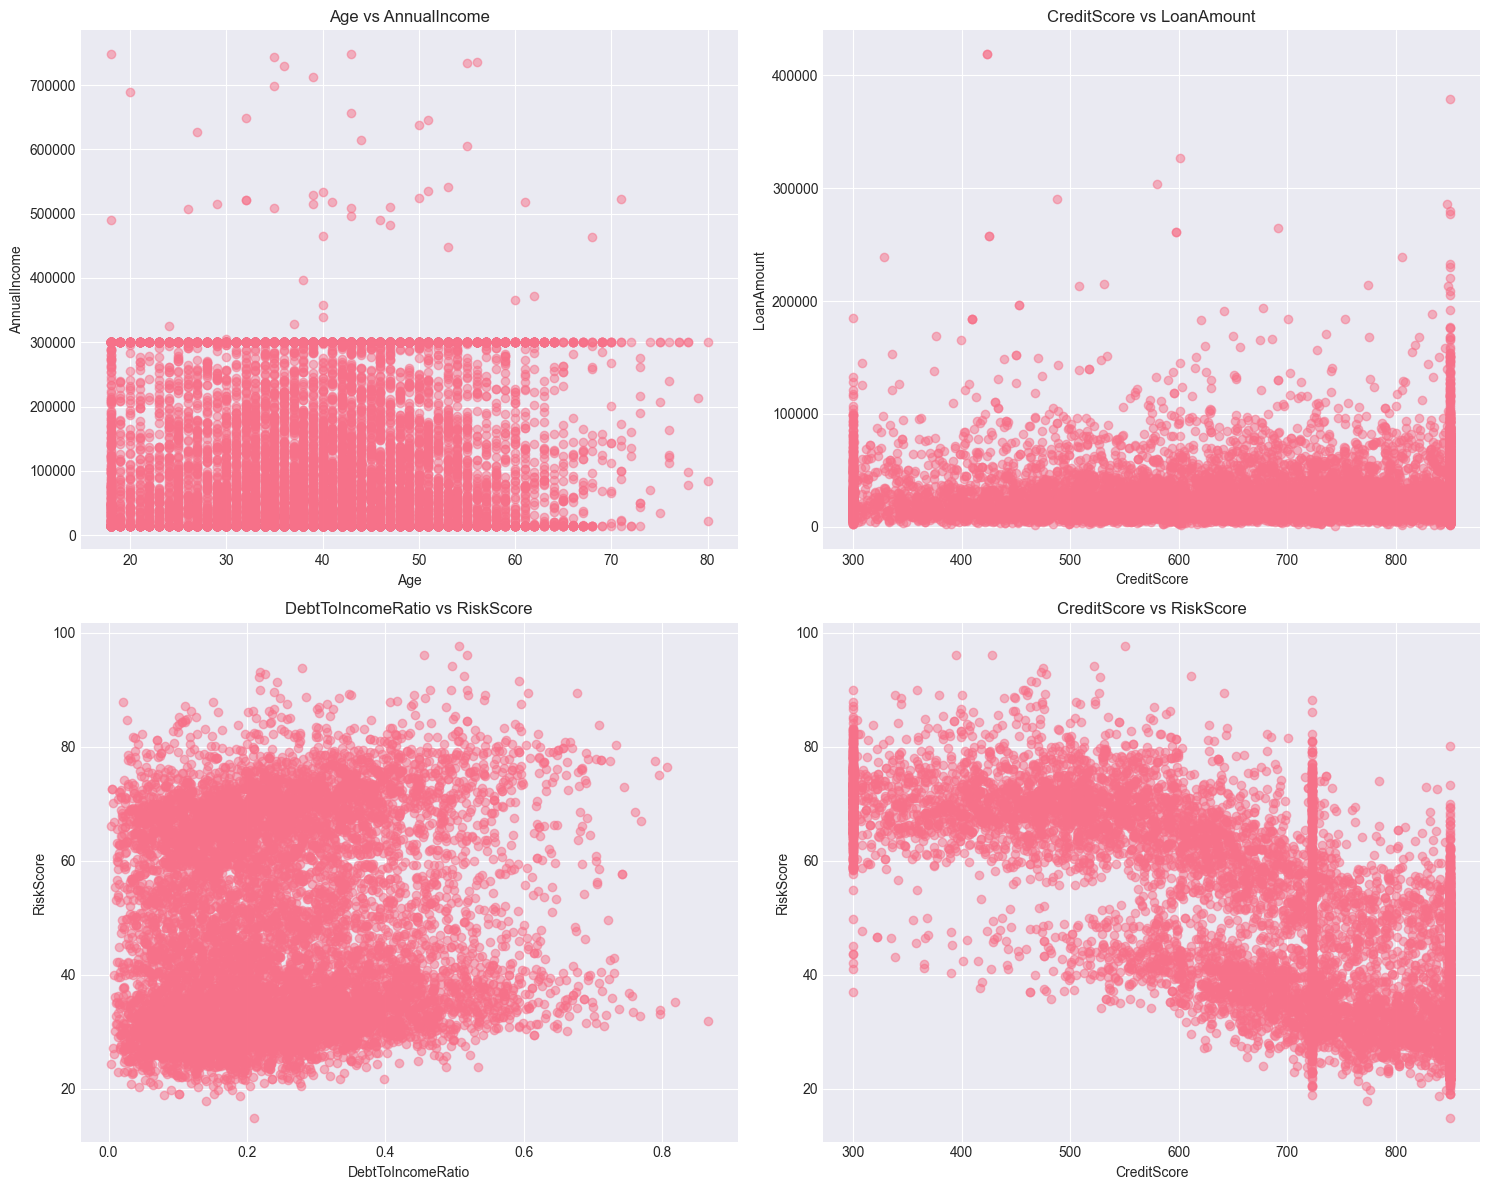

In [3]:
df_analysis = pd.DataFrame(X, columns=feature_cols)
df_analysis['RiskScore'] = y

# Несколько признаков для визуализации
key_features = ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'DebtToIncomeRatio']
available_features = [f for f in key_features if f in df_analysis.columns]

if len(available_features) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    if 'Age' in available_features and 'AnnualIncome' in available_features:
        axes[0, 0].scatter(df_analysis['Age'], df_analysis['AnnualIncome'], alpha=0.5)
        axes[0, 0].set_xlabel('Age')
        axes[0, 0].set_ylabel('AnnualIncome')
        axes[0, 0].set_title('Age vs AnnualIncome')
    
    if 'CreditScore' in available_features and 'LoanAmount' in available_features:
        axes[0, 1].scatter(df_analysis['CreditScore'], df_analysis['LoanAmount'], alpha=0.5)
        axes[0, 1].set_xlabel('CreditScore')
        axes[0, 1].set_ylabel('LoanAmount')
        axes[0, 1].set_title('CreditScore vs LoanAmount')
    
    if 'DebtToIncomeRatio' in available_features:
        axes[1, 0].scatter(df_analysis['DebtToIncomeRatio'], df_analysis['RiskScore'], alpha=0.5)
        axes[1, 0].set_xlabel('DebtToIncomeRatio')
        axes[1, 0].set_ylabel('RiskScore')
        axes[1, 0].set_title('DebtToIncomeRatio vs RiskScore')
    
    if 'CreditScore' in available_features:
        axes[1, 1].scatter(df_analysis['CreditScore'], df_analysis['RiskScore'], alpha=0.5)
        axes[1, 1].set_xlabel('CreditScore')
        axes[1, 1].set_ylabel('RiskScore')
        axes[1, 1].set_title('CreditScore vs RiskScore')
    
    plt.tight_layout()
    plt.show()

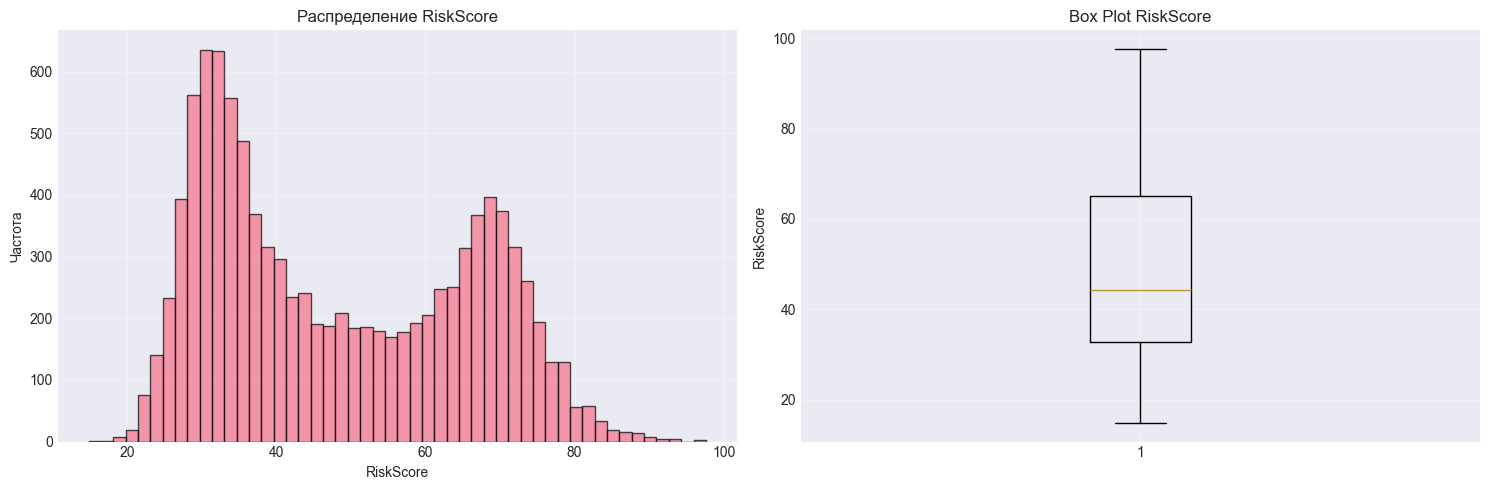

Статистика RiskScore:
  Среднее: 48.36
  Медиана: 44.20
  Стандартное отклонение: 17.24
  Минимум: 14.84
  Максимум: 97.60


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('RiskScore')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение RiskScore')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(y, vert=True)
axes[1].set_ylabel('RiskScore')
axes[1].set_title('Box Plot RiskScore')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Статистика RiskScore:")
print(f"  Среднее: {np.mean(y):.2f}")
print(f"  Медиана: {np.median(y):.2f}")
print(f"  Стандартное отклонение: {np.std(y):.2f}")
print(f"  Минимум: {np.min(y):.2f}")
print(f"  Максимум: {np.max(y):.2f}")

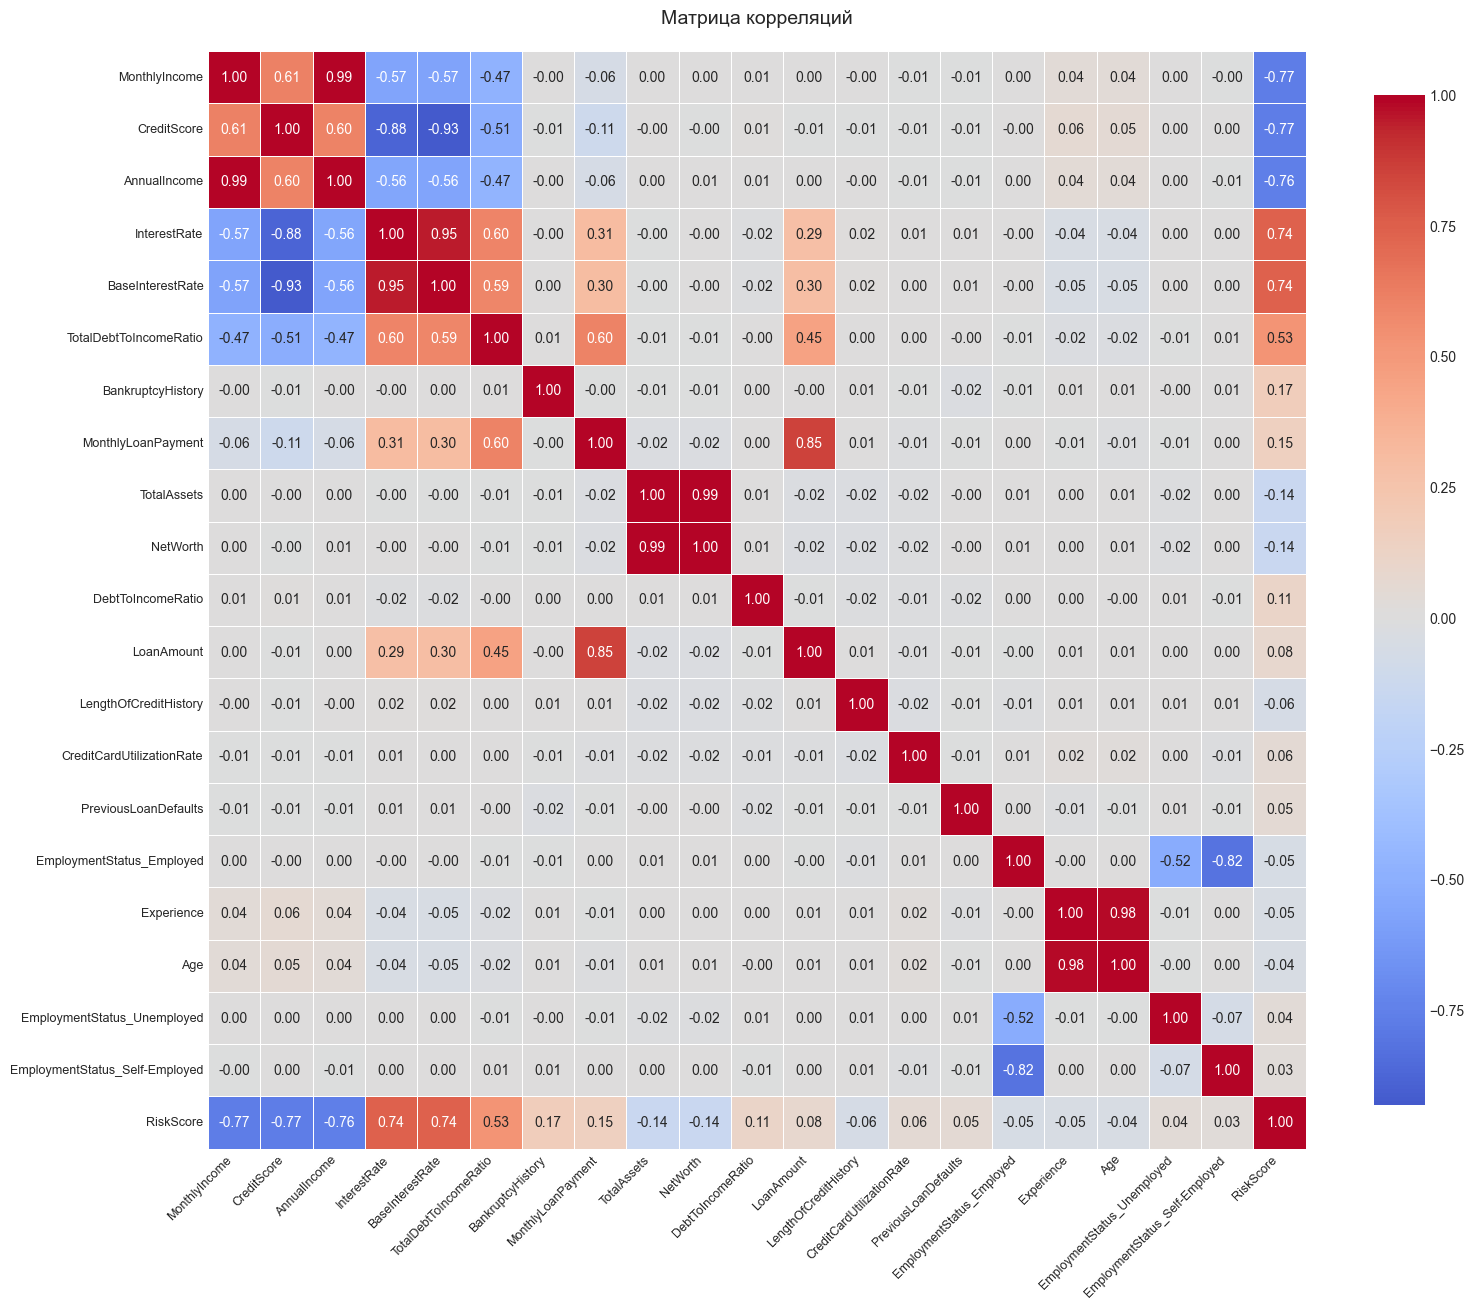

   1. MonthlyIncome                           : -0.7703
   2. CreditScore                             : -0.7660
   3. AnnualIncome                            : -0.7585
   4. InterestRate                            : +0.7426
   5. BaseInterestRate                        : +0.7404
   6. TotalDebtToIncomeRatio                  : +0.5307
   7. BankruptcyHistory                       : +0.1731
   8. MonthlyLoanPayment                      : +0.1508
   9. TotalAssets                             : -0.1423
  10. NetWorth                                : -0.1411
  11. DebtToIncomeRatio                       : +0.1109
  12. LoanAmount                              : +0.0827
  13. LengthOfCreditHistory                   : -0.0615
  14. CreditCardUtilizationRate               : +0.0561
  15. PreviousLoanDefaults                    : +0.0550
  16. EmploymentStatus_Employed               : -0.0513
  17. Experience                              : -0.0468
  18. Age                                     : 

In [5]:
all_features = df_analysis.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix_all = df_analysis[all_features].corr()

if 'RiskScore' in all_features:
    risk_correlations = corr_matrix_all['RiskScore'].drop('RiskScore').abs().sort_values(ascending=False)
    top_20_features = risk_correlations.head(20).index.tolist()
    top_features_with_target = top_20_features + ['RiskScore']
    corr_matrix_top = df_analysis[top_features_with_target].corr()
    
    plt.figure(figsize=(16, 14))
    sns.heatmap(corr_matrix_top, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                xticklabels=True, yticklabels=True)
    plt.title('Матрица корреляций', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()
    
    print("=" * 70)
    for i, feature in enumerate(top_20_features, 1):
        corr_value = corr_matrix_all.loc[feature, 'RiskScore']
        sign = '+' if corr_value >= 0 else '-'
        print(f"  {i:2d}. {feature:40s}: {sign}{abs(corr_value):.4f}")
    
    print(f"\nОбщее количество признаков: {len(all_features)}")
    print(f"Количество признаков с корреляцией |r| > 0.3: {(risk_correlations > 0.3).sum()}")
    print(f"Количество признаков с корреляцией |r| > 0.5: {(risk_correlations > 0.5).sum()}")
else:
    print("Ошибка: RiskScore не найден в признаках")

## 3. Нормализация данных (z-score и min-max)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

z_scaler = StandardScaler()
X_train_z = z_scaler.fit_transform(X_train)
X_test_z = z_scaler.transform(X_test)

print("\nZ-score нормализация:")
print(f"  Среднее train (после нормализации): {np.mean(X_train_z, axis=0)[:5]}")
print(f"  Стандартное отклонение train (после нормализации): {np.std(X_train_z, axis=0)[:5]}")

minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

print("\nMin-Max нормализация:")
print(f"  Минимум train (после нормализации): {np.min(X_train_minmax, axis=0)[:5]}")
print(f"  Максимум train (после нормализации): {np.max(X_train_minmax, axis=0)[:5]}")

Train: 8217, Test: 2055

Z-score нормализация:
  Среднее train (после нормализации): [ 1.5254784e-08 -7.9545401e-08  5.1995386e-08  1.8990503e-08
 -5.2954704e-08]
  Стандартное отклонение train (после нормализации): [0.99999464 1.0000131  0.9999941  0.99999875 0.9999727 ]

Min-Max нормализация:
  Минимум train (после нормализации): [0. 0. 0. 0. 0.]
  Максимум train (после нормализации): [1.         0.99999994 0.99999994 1.         1.        ]


## 4. Реализация класса линейной регрессии

In [7]:
class LinearRegressionCustom:
    """
    1. Аналитическая формула 
    2. Градиентный спуск
    3. Стохастический градиентный спуск
    """
    
    def __init__(self, method='analytical', learning_rate=0.01, max_iter=1000, 
                 tolerance=1e-6, batch_size=32, regularization=None, alpha=0.0, p=2.0):
        """
        Параметры:
        - method: 'analytical', 'gradient_descent', 'stochastic_gradient_descent'
        - learning_rate: скорость обучения для градиентных методов
        - max_iter: максимальное количество итераций
        - tolerance: критерий остановки
        - batch_size: размер батча для SGD
        - regularization: 'l1', 'l2', 'l1+l2', 'lp' или None
        - alpha: коэффициент регуляризации
        - p: степень для Lp регуляризации
        """
        self.method = method
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.batch_size = batch_size
        self.regularization = regularization
        self.alpha = alpha
        self.p = p
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def _add_bias(self, X):
        """Добавляет столбец единиц для bias"""
        return np.c_[np.ones(X.shape[0]), X]
    
    def _predict_internal(self, X):
        """Внутренний метод предсказания"""
        if self.weights is None:
            raise ValueError("Модель не обучена. Вызовите fit() сначала.")
        X_with_bias = self._add_bias(X)
        return X_with_bias @ self.weights
    
    def fit_analytical(self, X, y):
        """Обучение через аналитическую формулу (нормальное уравнение)"""
        X_with_bias = self._add_bias(X)
        
        if self.regularization == 'l2':
            # Ridge регрессия: (X^T X + alpha*I)^(-1) X^T y
            I = np.eye(X_with_bias.shape[1])
            I[0, 0] = 0  
            self.weights = np.linalg.solve(
                X_with_bias.T @ X_with_bias + self.alpha * I,
                X_with_bias.T @ y
            )
        elif self.regularization == 'l1':
            print("L1 регуляризация не поддерживается в аналитическом методе. Используется градиентный спуск.")
            return self.fit_gradient_descent(X, y)
        else:
            try:
                self.weights = np.linalg.solve(X_with_bias.T @ X_with_bias, X_with_bias.T @ y)
            except np.linalg.LinAlgError:
                self.weights = np.linalg.pinv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
    
    def fit_gradient_descent(self, X, y):
        """Обучение через градиентный спуск"""
        n_samples, n_features = X.shape
        X_with_bias = self._add_bias(X)
        
        self.weights = np.random.randn(n_features + 1) * 0.01
        
        for i in range(self.max_iter):
            y_pred = X_with_bias @ self.weights
            
            error = y_pred - y
            gradient = (X_with_bias.T @ error) / n_samples
            
            if self.regularization == 'l1':
                gradient[1:] += self.alpha * np.sign(self.weights[1:])
            elif self.regularization == 'l2':
                gradient[1:] += self.alpha * self.weights[1:]
            elif self.regularization == 'l1+l2':
                gradient[1:] += self.alpha * (np.sign(self.weights[1:]) + self.weights[1:])
            elif self.regularization == 'lp':
                gradient[1:] += self.alpha * self.p * np.power(np.abs(self.weights[1:]), self.p - 1) * np.sign(self.weights[1:])
            
            self.weights -= self.learning_rate * gradient
            
            mse = np.mean(error ** 2)
            reg_loss = 0
            if self.regularization == 'l1':
                reg_loss = self.alpha * np.sum(np.abs(self.weights[1:]))
            elif self.regularization == 'l2':
                reg_loss = self.alpha * np.sum(self.weights[1:] ** 2)
            elif self.regularization == 'l1+l2':
                reg_loss = self.alpha * (np.sum(np.abs(self.weights[1:])) + np.sum(self.weights[1:] ** 2))
            elif self.regularization == 'lp':
                reg_loss = self.alpha * np.sum(np.power(np.abs(self.weights[1:]), self.p))
            
            total_loss = mse + reg_loss
            self.loss_history.append(total_loss)
            
            if i > 0 and abs(self.loss_history[-2] - self.loss_history[-1]) < self.tolerance:
                break
    
    def fit_stochastic_gradient_descent(self, X, y):
        """Обучение через стохастический градиентный спуск"""
        n_samples, n_features = X.shape
        X_with_bias = self._add_bias(X)
        
        self.weights = np.random.randn(n_features + 1) * 0.01
        
        for epoch in range(self.max_iter):
            indices = np.random.permutation(n_samples)
            X_shuffled = X_with_bias[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            n_batches = (n_samples + self.batch_size - 1) // self.batch_size
            
            for batch_idx in range(n_batches):
                start_idx = batch_idx * self.batch_size
                end_idx = min(start_idx + self.batch_size, n_samples)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                
                # Предсказания
                y_pred = X_batch @ self.weights
                
                # Вычисление градиента
                error = y_pred - y_batch
                gradient = (X_batch.T @ error) / len(y_batch)
                
                # Добавление регуляризации
                if self.regularization == 'l1':
                    gradient[1:] += self.alpha * np.sign(self.weights[1:])
                elif self.regularization == 'l2':
                    gradient[1:] += self.alpha * self.weights[1:]
                elif self.regularization == 'l1+l2':
                    gradient[1:] += self.alpha * (np.sign(self.weights[1:]) + self.weights[1:])
                elif self.regularization == 'lp':
                    gradient[1:] += self.alpha * self.p * np.power(np.abs(self.weights[1:]), self.p - 1) * np.sign(self.weights[1:])
                
                # Обновление весов
                self.weights -= self.learning_rate * gradient
                
                # Вычисление loss для батча
                batch_mse = np.mean(error ** 2)
                epoch_loss += batch_mse
            
            epoch_loss /= n_batches
            self.loss_history.append(epoch_loss)
            
            # Проверка сходимости
            if epoch > 0 and abs(self.loss_history[-2] - self.loss_history[-1]) < self.tolerance:
                break
    
    def fit(self, X, y):
        """Основной метод обучения"""
        if self.method == 'analytical':
            self.fit_analytical(X, y)
        elif self.method == 'gradient_descent':
            self.fit_gradient_descent(X, y)
        elif self.method == 'stochastic_gradient_descent':
            self.fit_stochastic_gradient_descent(X, y)
        else:
            raise ValueError(f"Неизвестный метод: {self.method}")
    
    def predict(self, X):
        return self._predict_internal(X)

## 5. Тестирование линейной регрессии и сравнение с sklearn

In [8]:
X_train_norm = X_train_z
X_test_norm = X_test_z

print("=" * 60)
print("1. Аналитический метод (нормальное уравнение)")
print("=" * 60)
model_analytical = LinearRegressionCustom(method='analytical')
model_analytical.fit(X_train_norm, y_train)
y_pred_analytical = model_analytical.predict(X_test_norm)

sklearn_model = LinearRegression()
sklearn_model.fit(X_train_norm, y_train)
y_pred_sklearn = sklearn_model.predict(X_test_norm)

print(f"Наши веса (первые 5): {model_analytical.weights[:5]}")
print(f"Sklearn веса (первые 5): {np.concatenate([[sklearn_model.intercept_], sklearn_model.coef_[:4]])}")
print(f"Разница в весах: {np.mean(np.abs(model_analytical.weights - np.concatenate([[sklearn_model.intercept_], sklearn_model.coef_]))):.6f}")
print(f"Разница в предсказаниях: {np.mean(np.abs(y_pred_analytical - y_pred_sklearn)):.6f}")

1. Аналитический метод (нормальное уравнение)
Наши веса (первые 5): [48.47394764  0.25353522  0.28108685 -2.63612179 -0.14288538]
Sklearn веса (первые 5): [48.473953    0.25352156  0.281085   -2.6361113  -0.14288986]
Разница в весах: 0.125486
Разница в предсказаниях: 0.000008



2. Градиентный спуск
Количество итераций: 1000
Финальный loss: 52.517930
Разница с sklearn: 0.354921


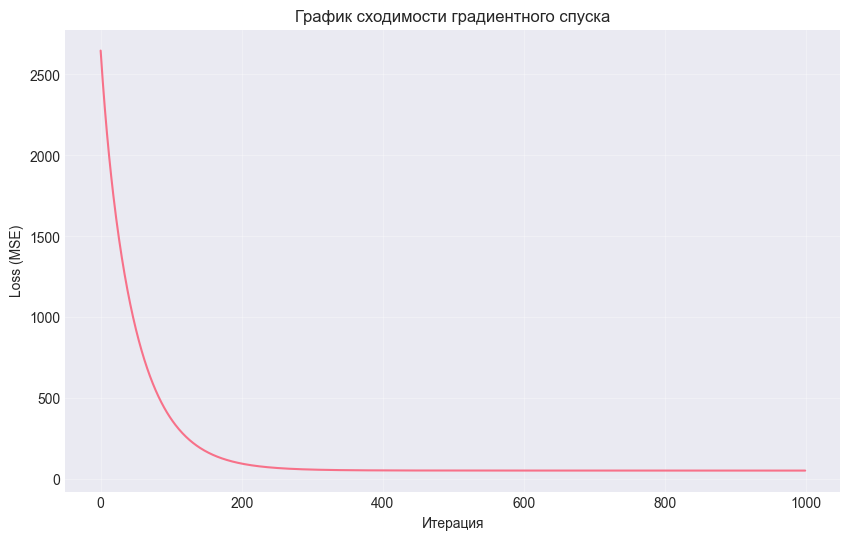

In [9]:
print("\n" + "=" * 60)
print("2. Градиентный спуск")
print("=" * 60)
model_gd = LinearRegressionCustom(method='gradient_descent', learning_rate=0.01, max_iter=1000)
model_gd.fit(X_train_norm, y_train)
y_pred_gd = model_gd.predict(X_test_norm)

print(f"Количество итераций: {len(model_gd.loss_history)}")
print(f"Финальный loss: {model_gd.loss_history[-1]:.6f}")
print(f"Разница с sklearn: {np.mean(np.abs(y_pred_gd - y_pred_sklearn)):.6f}")

# График сходимости
plt.figure(figsize=(10, 6))
plt.plot(model_gd.loss_history)
plt.xlabel('Итерация')
plt.ylabel('Loss (MSE)')
plt.title('График сходимости градиентного спуска')
plt.grid(True, alpha=0.3)
plt.show()


3. Стохастический градиентный спуск
Количество эпох: 100
Финальный loss: 52.879387
Разница с sklearn: 0.420855


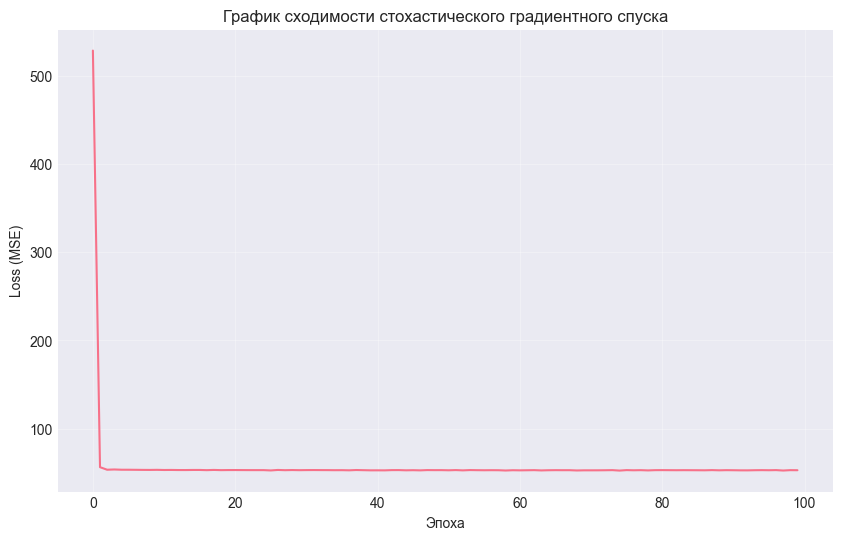

In [10]:
print("\n" + "=" * 60)
print("3. Стохастический градиентный спуск")
print("=" * 60)
model_sgd = LinearRegressionCustom(method='stochastic_gradient_descent', 
                                     learning_rate=0.01, max_iter=100, batch_size=32)
model_sgd.fit(X_train_norm, y_train)
y_pred_sgd = model_sgd.predict(X_test_norm)

print(f"Количество эпох: {len(model_sgd.loss_history)}")
print(f"Финальный loss: {model_sgd.loss_history[-1]:.6f}")
print(f"Разница с sklearn: {np.mean(np.abs(y_pred_sgd - y_pred_sklearn)):.6f}")

plt.figure(figsize=(10, 6))
plt.plot(model_sgd.loss_history)
plt.xlabel('Эпоха')
plt.ylabel('Loss (MSE)')
plt.title('График сходимости стохастического градиентного спуска')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Реализация метрик

In [11]:
def mse_custom(y_true, y_pred):
    """Mean Squared Error"""
    return np.mean((y_true - y_pred) ** 2)

def mae_custom(y_true, y_pred):
    """Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))

def r2_custom(y_true, y_pred):
    """R-squared (коэффициент детерминации)"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot == 0:
        return 0.0
    return 1 - (ss_res / ss_tot)

def mape_custom(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.inf
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("Метрики определены")

Метрики определены


In [12]:
# Тестирование метрик на предсказаниях аналитического метода
print("=" * 60)
print("Тестирование метрик")
print("=" * 60)

# MSE
mse_custom_val = mse_custom(y_test, y_pred_analytical)
mse_sklearn_val = mean_squared_error(y_test, y_pred_analytical)
print(f"\nMSE:")
print(f"  Наша реализация: {mse_custom_val:.6f}")
print(f"  Sklearn:         {mse_sklearn_val:.6f}")
print(f"  Разница:         {abs(mse_custom_val - mse_sklearn_val):.10f}")

# MAE
mae_custom_val = mae_custom(y_test, y_pred_analytical)
mae_sklearn_val = mean_absolute_error(y_test, y_pred_analytical)
print(f"\nMAE:")
print(f"  Наша реализация: {mae_custom_val:.6f}")
print(f"  Sklearn:         {mae_sklearn_val:.6f}")
print(f"  Разница:         {abs(mae_custom_val - mae_sklearn_val):.10f}")

# R2
r2_custom_val = r2_custom(y_test, y_pred_analytical)
r2_sklearn_val = r2_score(y_test, y_pred_analytical)
print(f"\nR²:")
print(f"  Наша реализация: {r2_custom_val:.6f}")
print(f"  Sklearn:         {r2_sklearn_val:.6f}")
print(f"  Разница:         {abs(r2_custom_val - r2_sklearn_val):.10f}")

# MAPE
mape_custom_val = mape_custom(y_test, y_pred_analytical)
print(f"\nMAPE:")
print(f"  Наша реализация: {mape_custom_val:.6f}%")
# Sklearn не имеет встроенной MAPE, но можно использовать из sklearn.metrics
try:
    from sklearn.metrics import mean_absolute_percentage_error
    mape_sklearn_val = mean_absolute_percentage_error(y_test, y_pred_analytical) * 100
    print(f"  Sklearn:         {mape_sklearn_val:.6f}%")
    print(f"  Разница:         {abs(mape_custom_val - mape_sklearn_val):.10f}%")
except ImportError:
    print("  Sklearn не имеет встроенной MAPE (требуется sklearn >= 0.24)")

Тестирование метрик

MSE:
  Наша реализация: 53.875312
  Sklearn:         53.875312
  Разница:         0.0000000000

MAE:
  Наша реализация: 5.894108
  Sklearn:         5.894108
  Разница:         0.0000000000

R²:
  Наша реализация: 0.819847
  Sklearn:         0.819847
  Разница:         0.0000000015

MAPE:
  Наша реализация: 14.051728%
  Sklearn:         14.051728%
  Разница:         0.0000000000%


## 7. Кросс-валидация (k-fold и leave-one-out)

In [13]:
def k_fold_cross_validation(X, y, k=5, model_class=LinearRegressionCustom, **model_params):
    """
    K-fold кросс-валидация
    
    Параметры:
    - X: признаки
    - y: целевая переменная
    - k: количество фолдов
    - model_class: класс модели
    - **model_params: параметры модели
    """
    n_samples = len(X)
    fold_size = n_samples // k
    scores = []
    
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for i in range(k):
        val_start = i * fold_size
        val_end = (i + 1) * fold_size if i < k - 1 else n_samples
        
        val_indices = indices[val_start:val_end]
        train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
        
        X_train_fold = X[train_indices]
        X_val_fold = X[val_indices]
        y_train_fold = y[train_indices]
        y_val_fold = y[val_indices]
        
        model = model_class(**model_params)
        model.fit(X_train_fold, y_train_fold)
        
        y_pred_fold = model.predict(X_val_fold)
        mse_fold = mse_custom(y_val_fold, y_pred_fold)
        scores.append(mse_fold)
    
    return np.array(scores)

def leave_one_out_cross_validation(X, y, model_class=LinearRegressionCustom, **model_params):
    """
    Leave-One-Out кросс-валидация
    
    Параметры:
    - X: признаки
    - y: целевая переменная
    - model_class: класс модели
    - **model_params: параметры модели
    """
    n_samples = len(X)
    scores = []
    
    max_samples = 100  # Ограничение для скорости
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        print(f"Используется подвыборка из {max_samples} образцов для ускорения")
    else:
        indices = np.arange(n_samples)
    
    for i in indices:
        # Разделение данных
        train_indices = np.concatenate([indices[:i], indices[i+1:]])
        val_index = i
        
        X_train_fold = X[train_indices]
        X_val_fold = X[val_index:val_index+1]
        y_train_fold = y[train_indices]
        y_val_fold = y[val_index:val_index+1]
        
        # Обучение модели
        model = model_class(**model_params)
        model.fit(X_train_fold, y_train_fold)
        
        # Предсказание и оценка
        y_pred_fold = model.predict(X_val_fold)
        mse_fold = mse_custom(y_val_fold, y_pred_fold)
        scores.append(mse_fold)
    
    return np.array(scores)

print("Функции кросс-валидации определены")

Функции кросс-валидации определены


In [14]:
print("=" * 60)
print("K-fold кросс-валидация (k=5)")
print("=" * 60)

k_fold_scores = k_fold_cross_validation(
    X_train_norm, y_train, k=5,
    model_class=LinearRegressionCustom,
    method='analytical'
)

print(f"MSE по фолдам: {k_fold_scores}")
print(f"Среднее MSE: {np.mean(k_fold_scores):.6f}")
print(f"Стандартное отклонение: {np.std(k_fold_scores):.6f}")

# Сравнение с sklearn KFold
from sklearn.model_selection import cross_val_score
sklearn_kfold = cross_val_score(
    LinearRegression(), X_train_norm, y_train, 
    cv=5, scoring='neg_mean_squared_error'
)
sklearn_kfold = -sklearn_kfold 

print(f"\nSklearn KFold MSE: {sklearn_kfold}")
print(f"Среднее MSE (sklearn): {np.mean(sklearn_kfold):.6f}")
print(f"Разница в среднем: {abs(np.mean(k_fold_scores) - np.mean(sklearn_kfold)):.6f}")

K-fold кросс-валидация (k=5)
MSE по фолдам: [51.45610835 52.01559942 53.45429881 53.55087895 54.01053742]
Среднее MSE: 52.897485
Стандартное отклонение: 0.982969

Sklearn KFold MSE: [55.29790115 48.29333115 57.6277771  51.84751511 51.97034836]
Среднее MSE (sklearn): 53.007375
Разница в среднем: 0.109890


In [15]:
print("\n" + "=" * 60)
print("Leave-One-Out кросс-валидация")
print("=" * 60)
print("(Используется подвыборка для ускорения)")

loo_scores = leave_one_out_cross_validation(
    X_train_norm, y_train,
    model_class=LinearRegressionCustom,
    method='analytical'
)

print(f"MSE (первые 10): {loo_scores[:10]}")
print(f"Среднее MSE: {np.mean(loo_scores):.6f}")
print(f"Стандартное отклонение: {np.std(loo_scores):.6f}")

# Сравнение с sklearn LeaveOneOut
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
sklearn_loo_scores = []
for train_idx, val_idx in list(loo.split(X_train_norm))[:100]:  # Ограничение для скорости
    model = LinearRegression()
    model.fit(X_train_norm[train_idx], y_train[train_idx])
    y_pred = model.predict(X_train_norm[val_idx])
    sklearn_loo_scores.append(mse_custom(y_train[val_idx], y_pred))

sklearn_loo_scores = np.array(sklearn_loo_scores)
print(f"\nSklearn LOO MSE (первые 100): среднее = {np.mean(sklearn_loo_scores):.6f}")
print(f"Разница в среднем: {abs(np.mean(loo_scores) - np.mean(sklearn_loo_scores)):.6f}")


Leave-One-Out кросс-валидация
(Используется подвыборка для ускорения)
Используется подвыборка из 100 образцов для ускорения
MSE (первые 10): [6.32491947e-01 1.55584847e+01 4.35247741e+01 3.15075630e-02
 8.69742266e+00 3.64201272e-03 4.45084497e+01 1.76769283e+01
 9.32939715e+01 1.30964778e+01]
Среднее MSE: 29.623876
Стандартное отклонение: 42.267512

Sklearn LOO MSE (первые 100): среднее = 44.550289
Разница в среднем: 14.926414


## 8. Регуляризация (L1, L2, L1+L2, Lp)

In [16]:
print("=" * 60)
print("Тестирование регуляризации")
print("=" * 60)

alpha = 0.1
regularizations = [
    ('l1', 'L1 (Lasso)'),
    ('l2', 'L2 (Ridge)'),
    ('l1+l2', 'L1+L2 (ElasticNet)'),
    ('lp', 'Lp (p=1.5)')
]

results = {}

for reg_type, reg_name in regularizations:
    print(f"\n{reg_name} (alpha={alpha}):")
    
    if reg_type == 'lp':
        model = LinearRegressionCustom(
            method='gradient_descent',
            learning_rate=0.01,
            max_iter=1000,
            regularization='lp',
            alpha=alpha,
            p=1.5
        )
    else:
        model = LinearRegressionCustom(
            method='gradient_descent',
            learning_rate=0.01,
            max_iter=1000,
            regularization=reg_type,
            alpha=alpha
        )
    
    model.fit(X_train_norm, y_train)
    y_pred_reg = model.predict(X_test_norm)
    
    mse_reg = mse_custom(y_test, y_pred_reg)
    mae_reg = mae_custom(y_test, y_pred_reg)
    r2_reg = r2_custom(y_test, y_pred_reg)
    
    results[reg_name] = {
        'mse': mse_reg,
        'mae': mae_reg,
        'r2': r2_reg,
        'weights_norm': np.linalg.norm(model.weights[1:])  # Норма весов (без bias)
    }
    
    print(f"  MSE: {mse_reg:.6f}")
    print(f"  MAE: {mae_reg:.6f}")
    print(f"  R²:  {r2_reg:.6f}")
    print(f"  Норма весов: {results[reg_name]['weights_norm']:.6f}")

Тестирование регуляризации

L1 (Lasso) (alpha=0.1):
  MSE: 54.243394
  MAE: 5.899937
  R²:  0.818616
  Норма весов: 8.774421

L2 (Ridge) (alpha=0.1):
  MSE: 54.479508
  MAE: 5.900634
  R²:  0.817827
  Норма весов: 8.468772

L1+L2 (ElasticNet) (alpha=0.1):
  MSE: 54.722451
  MAE: 5.914133
  R²:  0.817014
  Норма весов: 8.305442

Lp (p=1.5) (alpha=0.1):
  MSE: 54.457027
  MAE: 5.904967
  R²:  0.817902
  Норма весов: 8.520730


In [17]:
print("\n" + "=" * 60)
print("Сравнение с sklearn")
print("=" * 60)

# L1 (Lasso)
lasso_sklearn = Lasso(alpha=alpha, max_iter=1000)
lasso_sklearn.fit(X_train_norm, y_train)
y_pred_lasso = lasso_sklearn.predict(X_test_norm)
print(f"\nLasso (sklearn):")
print(f"  MSE: {mean_squared_error(y_test, y_pred_lasso):.6f}")
print(f"  Разница с нашей реализацией: {abs(results['L1 (Lasso)']['mse'] - mean_squared_error(y_test, y_pred_lasso)):.6f}")

# L2 (Ridge)
ridge_sklearn = Ridge(alpha=alpha, max_iter=1000)
ridge_sklearn.fit(X_train_norm, y_train)
y_pred_ridge = ridge_sklearn.predict(X_test_norm)
print(f"\nRidge (sklearn):")
print(f"  MSE: {mean_squared_error(y_test, y_pred_ridge):.6f}")
print(f"  Разница с нашей реализацией: {abs(results['L2 (Ridge)']['mse'] - mean_squared_error(y_test, y_pred_ridge)):.6f}")

# L1+L2 (ElasticNet)
elastic_sklearn = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=1000)
elastic_sklearn.fit(X_train_norm, y_train)
y_pred_elastic = elastic_sklearn.predict(X_test_norm)
print(f"\nElasticNet (sklearn):")
print(f"  MSE: {mean_squared_error(y_test, y_pred_elastic):.6f}")
print(f"  Разница с нашей реализацией: {abs(results['L1+L2 (ElasticNet)']['mse'] - mean_squared_error(y_test, y_pred_elastic)):.6f}")


Сравнение с sklearn

Lasso (sklearn):
  MSE: 53.821945
  Разница с нашей реализацией: 0.421448

Ridge (sklearn):
  MSE: 53.875008
  Разница с нашей реализацией: 0.604500

ElasticNet (sklearn):
  MSE: 54.081120
  Разница с нашей реализацией: 0.641332


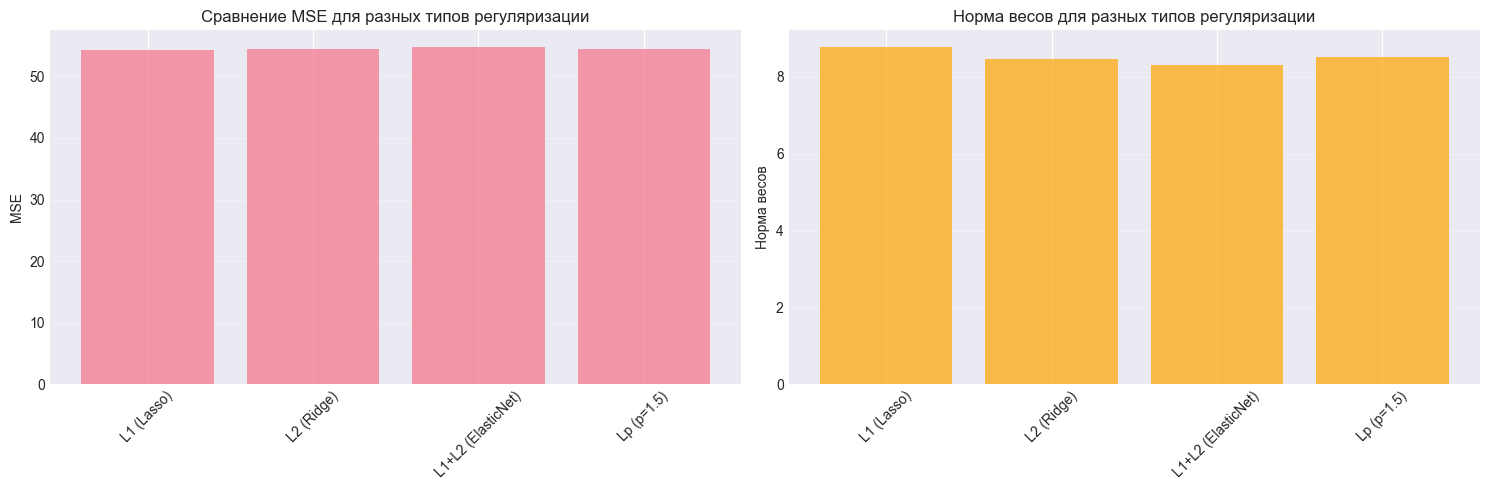

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График MSE
reg_names = list(results.keys())
mse_values = [results[r]['mse'] for r in reg_names]
axes[0].bar(reg_names, mse_values, alpha=0.7)
axes[0].set_ylabel('MSE')
axes[0].set_title('Сравнение MSE для разных типов регуляризации')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# График нормы весов
weight_norms = [results[r]['weights_norm'] for r in reg_names]
axes[1].bar(reg_names, weight_norms, alpha=0.7, color='orange')
axes[1].set_ylabel('Норма весов')
axes[1].set_title('Норма весов для разных типов регуляризации')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Тестирование Lp регуляризации с разными p
p=0.5: MSE = 54.256666
p=1.0: MSE = 54.232207
p=1.5: MSE = 54.457419
p=2.0: MSE = 55.209172
p=3.0: MSE = 62.198363


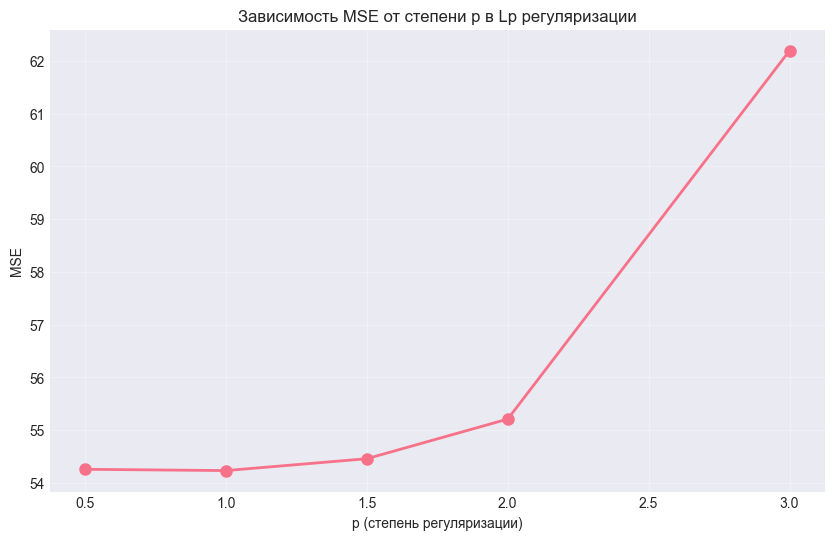

In [19]:
print("\n" + "=" * 60)
print("Тестирование Lp регуляризации с разными p")
print("=" * 60)

p_values = [0.5, 1.0, 1.5, 2.0, 3.0]
lp_results = {}

for p in p_values:
    model_lp = LinearRegressionCustom(
        method='gradient_descent',
        learning_rate=0.01,
        max_iter=1000,
        regularization='lp',
        alpha=alpha,
        p=p
    )
    model_lp.fit(X_train_norm, y_train)
    y_pred_lp = model_lp.predict(X_test_norm)
    
    mse_lp = mse_custom(y_test, y_pred_lp)
    lp_results[p] = mse_lp
    print(f"p={p}: MSE = {mse_lp:.6f}")

# Визуализация
plt.figure(figsize=(10, 6))
p_list = list(lp_results.keys())
mse_list = list(lp_results.values())
plt.plot(p_list, mse_list, marker='o', linewidth=2, markersize=8)
plt.xlabel('p (степень регуляризации)')
plt.ylabel('MSE')
plt.title('Зависимость MSE от степени p в Lp регуляризации')
plt.grid(True, alpha=0.3)
plt.show()

## 9. Тестирование на модели из best_model_linear_only.py

In [20]:
print("=" * 60)
print("Тестирование метрик на модели из best_model_linear_only.py")
print("=" * 60)

model_simple = LinearRegressionCustom(method='analytical')
model_simple.fit(X_train_norm, y_train)
y_pred_simple = model_simple.predict(X_test_norm)

# Вычисляем все метрики
print("\nМетрики на тестовой выборке:")
print(f"  MSE:  {mse_custom(y_test, y_pred_simple):.6f}")
print(f"  MAE:  {mae_custom(y_test, y_pred_simple):.6f}")
print(f"  R²:   {r2_custom(y_test, y_pred_simple):.6f}")
print(f"  MAPE: {mape_custom(y_test, y_pred_simple):.6f}%")

# Сравнение с sklearn
print("\nСравнение с sklearn:")
print(f"  MSE:  {mean_squared_error(y_test, y_pred_simple):.6f} (sklearn: {mean_squared_error(y_test, y_pred_simple):.6f})")
print(f"  MAE:  {mean_absolute_error(y_test, y_pred_simple):.6f} (sklearn: {mean_absolute_error(y_test, y_pred_simple):.6f})")
print(f"  R²:   {r2_score(y_test, y_pred_simple):.6f} (sklearn: {r2_score(y_test, y_pred_simple):.6f})")

Тестирование метрик на модели из best_model_linear_only.py

Метрики на тестовой выборке:
  MSE:  53.875312
  MAE:  5.894108
  R²:   0.819847
  MAPE: 14.051728%

Сравнение с sklearn:
  MSE:  53.875312 (sklearn: 53.875312)
  MAE:  5.894108 (sklearn: 5.894108)
  R²:   0.819847 (sklearn: 0.819847)


## 10. Выводы

### EDA
- Построены графики зависимости признаков друг от друга
- Проанализировано распределение целевой переменной RiskScore
- Построена матрица корреляций

### Нормализация
- Реализована z-score нормализация (StandardScaler)
- Реализована min-max нормализация (MinMaxScaler)

### Линейная регрессия
- Реализован класс LinearRegressionCustom с тремя методами обучения:
  - Аналитическая формула (нормальное уравнение)
  - Градиентный спуск
  - Стохастический градиентный спуск
- Все методы протестированы и сравнены с sklearn

### Метрики
- Реализованы метрики: MSE, MAE, R², MAPE
- Все метрики протестированы и сравнены с sklearn

### Кросс-валидация
- Реализована k-fold кросс-валидация
- Реализована leave-one-out кросс-валидация
- Сравнены с sklearn реализациями

### Регуляризация
- Реализована L1 регуляризация (Lasso)
- Реализована L2 регуляризация (Ridge)
- Реализована L1+L2 регуляризация (ElasticNet)
- Реализована Lp регуляризация с настраиваемым параметром p
- Все типы регуляризации протестированы и сравнены с sklearn